In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
from meshed import FuncNode
from meshed.tests import objects_for_testing as ot
dir(ot)

['DAG',
 'FuncNode',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dag_plus_and_times',
 'dag_plus_and_times_ext',
 'dag_plus_times_minus',
 'dag_plus_times_minus_partial',
 'f',
 'f_node',
 'g',
 'g_node',
 'h',
 'signature']

# Dealing with iterables in DAGs

The problem: When a function/node outputs/provides an iterable (that can only be iterated through once), and we have two consumers of it. 

The solution is not (always) `itertools.tee` since that is expensive memory-wise. 

We need some solutions/tools that allow us to trade less memory for more computation, i/o, etc. 

This is related to caching. 

See [Consuming iterators/generator multiple times](https://github.com/i2mint/meshed/discussions/56) for more info.

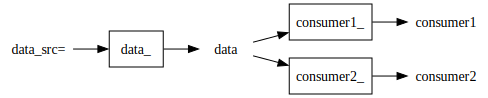

In [1]:
def data(data_src=[1, 2, 3]):
    for d in data_src:
        yield d

def consumer1(data):
    return [x * 2 for x in data]
        
    
def consumer2(data):
    return [x * 10 for x in data]


from meshed import DAG

dag1 = DAG([data, consumer1, consumer2])
dag1.dot_digraph("rankdir=LR")
        

The problem is that when the `consumer` consumes the iterable, it's already consumed when `consumer2` needs to do its work:

In [2]:
assert dag1() == ([2, 4, 6], [])  # we ACTUALLY want: ([2, 4, 6], [20, 40, 60])

One solution is to use `itertools.tee`:

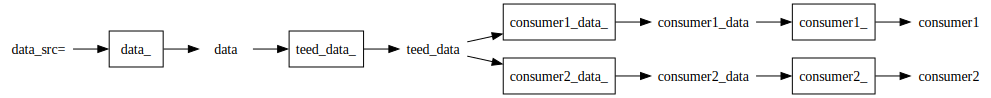

In [4]:
from itertools import tee
import i2

def teed_data(data):
    return tee(data, 2)

def consumer1_data(teed_data):
    return teed_data[0]

def consumer2_data(teed_data):
    return teed_data[1]

def consumer1(consumer1_data):
    return [x * 2 for x in consumer1_data]
        
def consumer2(consumer2_data):
    return [x * 10 for x in consumer2_data]


dag2 = DAG([data, teed_data, consumer1_data, consumer2_data, consumer1, consumer2])

dag2.dot_digraph("rankdir=LR")


In [5]:
# And now we get what we want:
assert dag2() == ([2, 4, 6], [10, 20, 30])

## Special case: partitions

If we're in a case where actually `consumer1` and `consumer2` are really plucking off different items of the data, we're in a "partition" case, and could solve it this way:

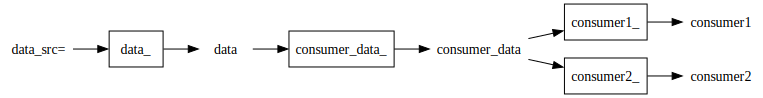

In [8]:
from more_itertools import partition

def is_odd(x):
    return x % 2 != 1

def consumer_data(data):
    consumer1, consumer2 = partition(is_odd, data())
    return consumer1, consumer2
    
def consumer1(consumer_data):
    return consumer_data[0]

def consumer2(consumer_data):
    return consumer_data[1]

dag3 = DAG([data, consumer_data, consumer1, consumer2])
dag3.dot_digraph("rankdir=LR")

## Trading computation for memory

The problem with using `itertools.tee` is that the way it works is to keep a copy of the iterable items in memory until all consumers have processed said item. 

If the two consumers consume in parallel, or even better, in an cooperative "iterlaced" way (item1 is taken care of by each consumer, then item2, etc.) as in `partition`, this is not much of a problem.

But, on the other hand of the spectrum, if the consumers process all the items in turn, one after the other (that is, `consumer1` processes all the items, then `consumer2` processes all the items), as is the case in the default execution model of `DAG`, then this can get very expensive memory-wise. 



To be continued...

# FuncMesh

A `DAG`, in the "Direct Acyclic Graph" sense, as well as in the sense "bipartite graph of variable nodes and function nodes", but where, unlike `meshed.DAG`:
* A variable node can have more than one function node providing its data
* A function node can be the provider of more than one node

# DAG function injection

In [1]:
import importlib
import plunk
import plunk.tw.i2i_demos
import plunk.tw.i2i_demos.play
import plunk.tw.i2i_demos.play.resources
importlib.reload(plunk.tw.i2i_demos.play.resources)

from plunk.tw.i2i_demos.play.resources import dag

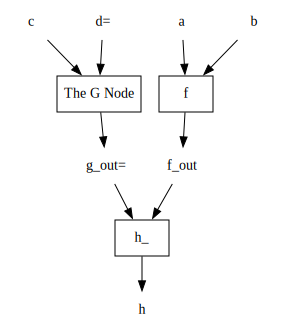

In [18]:
from meshed.tests.objects_for_testing import dag_plus_times_minus as d
from meshed import dag
import i2

d.dot_digraph()

In [19]:
dag.print_dag_string(d)

a,b -> f -> f_out
c,d -> g -> g_out
ff=f_out,gg=g_out -> h_ -> h


In [20]:
print(*(x.bind for x in d.func_nodes), sep='\n')

{'a': 'a', 'b': 'b'}
{'c': 'c', 'd': 'd'}
{'ff': 'f_out', 'gg': 'g_out'}


In [46]:
d(1,2,3)

9

In [51]:
dd = d.ch_funcs(f=lambda a, b: a / b)
dd(1, 2, 3)

11.5

In [23]:
import i2.wrapper as i2w

i2w.kwargs_trans()

functools.partial(<function kwargs_trans at 0x111ecb6d0>, _recursive=False, _inplace=False)

In [24]:
# raises a ValueError since the signature doesn't match the signature of `f` exactly

import pytest

f2 = lambda a, bb: a / bb

with pytest.raises(ValueError):
    dd = d.ch_funcs(f=f2)

### Solution A: Wrap function to match expected signature

In [50]:
# we can change the name of `bb` to be `b` to fix that
from i2 import ch_names

dd = d.ch_funcs(f=ch_names(f2, bb='b'))
dd(1, 2, 3)

11.5

### Solution B: Change the bindings

In [58]:
from meshed.base import rebind_to_func

f2 = lambda a, bb: a / bb
dd = d.ch_funcs(rebind_to_func, f=f2)
dd(1, 2, 3)

11.5

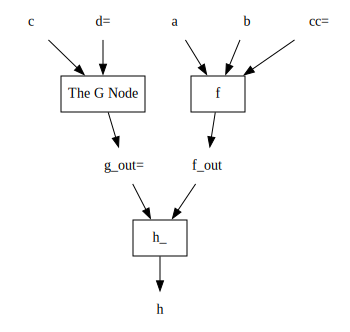

In [59]:
f3 = lambda a, bb, cc=1: a / (bb * cc)

dd = d.ch_funcs(rebind_to_func, f=f3)
dd.dot_digraph()

## fn trans scrap

In [56]:
d.func_nodes

[FuncNode(a,b -> f -> f_out),
 FuncNode(c,d -> g -> g_out),
 FuncNode(ff=f_out,gg=g_out -> h_ -> h)]

In [63]:
fn = d._func_node_for['f']
fn

FuncNode(a,b -> f -> f_out)

In [67]:
fnd = fn.to_dict()
fnd

{'func': <function meshed.tests.objects_for_testing.f(a, b)>,
 'name': 'f',
 'bind': {'a': 'a', 'b': 'b'},
 'out': 'f_out',
 'func_label': 'f',
 'names_maker': <function meshed.base.underscore_func_node_names_maker(func: Callable, name=None, out=None)>,
 'node_validator': <function meshed.base.basic_node_validator(func_node)>}

In [77]:
def order_keys(d: dict, keys):
    return {k: d[k] for k in keys}


In [76]:
ff = lambda a, bb: a / bb
fnd['bind'] = 
assert list(fnd['bind']) == Sig(fnd['func']).names

Sig(ff)

<Sig (a, bb)>

In [71]:
Sig(fnd['func'])

<Sig (a, b)>

In [34]:
from functools import partial
from meshed.util import parameter_merger

param_merge = partial(parameter_merger, same_name=False)

In [35]:
from i2 import Sig

f = d['f':'f'].func_nodes[0].func
p1 = list(Sig(f).params)
p2 = list(Sig(f2).params)
p1, p2

([<Parameter "a">, <Parameter "b">], [<Parameter "a">, <Parameter "bb">])

In [36]:
param_merge(zip(p1, p2))

(<Parameter "a">, <Parameter "a">)

In [52]:
param_merge = partial(parameter_merger, same_name=False)
param_merge(p1[1], p2[1])

<Parameter "b">

In [50]:
from inspect import Parameter as P

PK = P.POSITIONAL_OR_KEYWORD
KO = P.KEYWORD_ONLY
# parameter_merger([P('a', PK), P('a', KO)])

In [49]:
def foo(*args, b=1):
    pass

Sig(foo).params[1].kind

<_ParameterKind.KEYWORD_ONLY: 3>

In [54]:
d

DAG(func_nodes=[FuncNode(a,b -> f -> f_out), FuncNode(c,d -> g -> g_out), FuncNode(ff=f_out,gg=g_out -> h_ -> h)], name=None)

In [12]:
from types import SimpleNamespace

t = SimpleNamespace()
t.blah = 3
t

namespace(blah=3)

In [13]:
with dag.editor() as e:
    e.f = lambda a, b: a / b
    e.g(bind='fdf')

AttributeError: module 'meshed.dag' has no attribute 'editor'

In [3]:
from i2.footprints import MethodTrace

e = MethodTrace()
e.f = lambda a, b: a / b
e.trace

[]

In [4]:
import pickle

e = MethodTrace()
pickle.loads(pickle.dumps(e))

<MethodTrace with .trace = >

In [69]:
from i2.footprints import MethodTrace

def is_not_dunder(attr_name: str):
    return not attr_name.startswith('__') or not attr_name.endswith('__')


class NewMethodTrace(MethodTrace):
    def __init__(self, include=None):
        self.include = include
        self.trace = []

    def __repr__(self):
        trace_str = ', '.join(map(lambda x: f'{x}', self.trace))
        return f'<{type(self).__name__} with .trace = {trace_str}>'

    def _should_be_traced(self, attr_name: str):
        if self.include:
            return attr_name in self.include
        else:
            return is_not_dunder(attr_name)
        
    def __getattr__(self, attr_name: str):
        
        if self._should_be_traced(attr_name):
            def traced_operation(*args, **kwargs):
                self.trace.append((attr_name, args, kwargs))
                return self

            return traced_operation
        else:
            try:
                self.__dict__[attr_name]
            except KeyError as e:
                raise AttributeError(*e.args)
    
t = NewMethodTrace()

t.foo(1, bar=2)
t.only_pos(3, 4)
t.only_kw(this=3, that=4)
t + 2
t.trace
assert t.trace == [
    ('foo', (1,), {'bar': 2}),
    ('only_pos', (3, 4), {}),
    ('only_kw', (), {'this': 3, 'that': 4}),
    ('__add__', 2)
]


[('foo', (1,), {'bar': 2}),
 ('only_pos', (3, 4), {}),
 ('only_kw', (), {'this': 3, 'that': 4}),
 ('__add__', 2)]

In [70]:
import pickle

pickle.dumps(t)

b'\x80\x04\x95\x9b\x00\x00\x00\x00\x00\x00\x00\x8c\x08__main__\x94\x8c\x0eNewMethodTrace\x94\x93\x94)\x81\x94}\x94(\x8c\x07include\x94N\x8c\x05trace\x94]\x94(\x8c\x03foo\x94K\x01\x85\x94}\x94\x8c\x03bar\x94K\x02s\x87\x94\x8c\x08only_pos\x94K\x03K\x04\x86\x94}\x94\x87\x94\x8c\x07only_kw\x94)}\x94(\x8c\x04this\x94K\x03\x8c\x04that\x94K\x04u\x87\x94\x8c\x07__add__\x94K\x02\x86\x94eub.'

In [52]:
e = NewMethodTrace(include=['g'])
# e.f = lambda a, b: a / b  # need descriptors to be able to catch this assignment
# e.f('asdf')
e.f(1,2,3)
e.trace

f


AttributeError: f

In [28]:
t.trace

[('foo', (1,), {'bar': 2})]

In [ ]:
def include_exclude_

In [24]:
import pickle

# e = NewMethodTrace()
pickle.loads(pickle.dumps(t))

<NewMethodTrace with .trace = ('foo', (1,), {'bar': 2})>

In [108]:
def foo(a):
    return a + 2

In [ ]:
# bar = sig(foo)

# Module to DAG of callables

In [17]:
from functools import partial

from meshed import iterize
from i2 import Pipe, Sig

def has_signature(x, signature_func=Sig):
    try:
        signature_func(x)
        return True
    except Exception as e:
        return False
        
def true_no_matter_what(x):
    return True

mk_filter = lambda filt: partial(filter, filt)

def module_callables(module, filt=true_no_matter_what, is_callable=has_signature):
    f = Pipe(
        dir,
        mk_filter(lambda x: not x.startswith('__')),
        mk_filter(filt),
        iterize(lambda a: getattr(module, a)),
        mk_filter(is_callable),
        mk_filter(
            lambda obj: getattr(obj, '__module__', None) == module.__name__),
        list
    )
    return f(module)



import wealth.aligned_umap_analysis as module
# import meshed.util as module
# import wave as module
# import functools as module
funcs = module_callables(module, filt=lambda x: not x.startswith('assert'))

from meshed import DAG
from meshed.util import parameter_merger
from functools import partial

dag = DAG(funcs, 
    parameter_merge=partial(parameter_merger, 
                            same_kind=False,
                            same_default=False,
                            same_annotation=False)
   )

# dag.dot_digraph(start_lines=['rankdir=LR;'])

# From annotations to meshes

In [32]:
from meshed.scrap.annotations_to_meshes import *

# see code and tests there.

In [1]:
from typing import MutableMapping, Iterable, Any, NewType, Callable

Group = NewType('Group', str)
Item = NewType('Item', Any)

class Groups:
    add_item_to_group: Callable[[Item, Group], Any]
    add_items_to_group: Callable[[Iterable[Item], Group], Any]
    list_groups: Callable[[], Iterable[Group]]
    items_for_group: Callable[[Group], Iterable[Item]]
    

In [2]:
from typing import Protocol

class GroupsProtocol(Protocol):
    def add_items_to_group(self, item: Item, group: Group) -> Any:
        pass
        
    def add_items_to_group(self, items: Iterable[Item], group: Group) -> Any:
        pass
    
    def list_groups(self) -> Iterable[Group]:
        pass
        
    def items_for_group(self, group: Group) -> Iterable[Item]:
        pass

# IEC 61499 (Jittery Bob)

Jittery Bob??! Huh?|

See [Mnemonic major system](https://en.wikipedia.org/wiki/Mnemonic_major_system#:~:text=The%20major%20system%20(also%20called,into%20words%20by%20adding%20vowels.)

In [150]:
class FunctionBlock:
    def __init__(self, inputs=[], outputs=[]):
        self.inputs = inputs
        self.outputs = outputs
        self.state = {}

    def execute(self):
        pass

class BasicFB(FunctionBlock):
    def __init__(self, inputs=[], outputs=[], parameters=[]):
        super().__init__(inputs, outputs)
        self.parameters = parameters

    def execute(self):
        # Do some computation with inputs and parameters
        # Set the outputs accordingly
        pass

class CompositeFB(FunctionBlock):
    def __init__(self, inputs=[], outputs=[], sub_blocks=[]):
        super().__init__(inputs, outputs)
        self.sub_blocks = sub_blocks

    def execute(self):
        # Execute sub-blocks in parallel or in sequence
        pass
    

class Adder(FunctionBlock):
    def __init__(self):
        super().__init__(inputs=['a', 'b'], outputs=['sum'])

    def execute(self):
        self.state['sum'] = self.inputs['a'] + self.inputs['b']


class Multiplier(FunctionBlock):
    def __init__(self):
        super().__init__(inputs=['a', 'b'], outputs=['product'])

    def execute(self):
        self.state['product'] = self.inputs['a'] * self.inputs['b']


class SquareRoot(FunctionBlock):
    def __init__(self):
        super().__init__(inputs=['value'], outputs=['result'])

    def execute(self):
        self.state['result'] = math.sqrt(self.inputs['value'])
        
        
# Create instances of the function blocks
adder = Adder()
multiplier = Multiplier()
square_root = SquareRoot()

# Connect the blocks together
adder.outputs['sum'] = multiplier.inputs['a']
multiplier.outputs['product'] = square_root.inputs['value']

# Set input values
adder.inputs['a'] = 2
adder.inputs['b'] = 3

# Execute the blocks
adder.execute()
multiplier.execute()
square_root.execute()

# Retrieve the output values
result = square_root.state['result']
print(result) # Output: 2.23606797749979

TypeError: list indices must be integers or slices, not str

In [151]:
adder.outputs

['sum']

# Reactive scope

In [118]:
from meshed.scrap.reactive_scope import *
from meshed.tests import objects_for_testing as ot


In [148]:
from meshed import FuncNode, DAG
from meshed.scrap.reactive_scope import ReactiveScope

def f(a, b):
    return a + b


def g(a_plus_b, d):
    return a_plus_b * d

f_node = FuncNode(func=f, out='a_plus_b')
g_node = FuncNode(func=g, bind={'d': 'b'})
d = DAG((f_node, g_node))

d.dot_digraph()

s = ReactiveScope(d)
s

s['g']
    
    
# But if you give `g_` enough data to be able to compute...
s['b'] = 3
s['a_plus_b'] = 5
# ... you'll be able to get 'g'
s['g']

s

# Note that 'a' isn't in the scope here.
# Let's clear the scope and do something else with it.

s.clear()
s

s['a'] = 3
s['b'] = 4
s['g']  # (3 + 4) * 4 == 7 * 4 == 28

<ReactiveScope with .scope: {}>

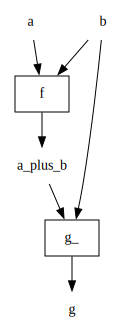

In [119]:
d = ot.dag_plus_and_times_ext
d.dot_digraph()

In [120]:
import pytest

In [121]:
s = ReactiveScope(d)

In [124]:
s

<ReactiveScope with .scope: {}>

In [113]:
# Can't get 'g' yet because it hasn't been "made"
with pytest.raises(KeyError, match="'g'"):
    s['g']

In [114]:
# But if you give `g_` enough data to be able to compute...
s['b'] = 3
s['a_plus_b'] = 5
# ... you'll be able to get 'g'
s['g']

15

In [115]:
s

<ReactiveScope with .scope: {'b': 3, 'a_plus_b': 5, 'g': 15}>

Note that `'a'` isn't in the scope here.

Let's clear the scope and do something else with it.

In [116]:
s.clear()
s

<ReactiveScope with .scope: {}>

Instead of giving it `a_plus_b`, we'll give it `a`. 
Since `a` and `b` suffice for `f` to compute `a_plus_b`, it's value will be computed, hence providing sufficient data to compute `g`: 

In [117]:
s['a'] = 3
s['b'] = 4
s['g']  # (3 + 4) * 4 == 7 * 4 == 28

28

In [126]:
s

<ReactiveScope with .scope: {}>

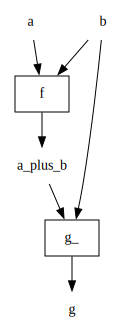

In [141]:
d.dot_digraph()

In [142]:
s['g'] = 16
s['g']

16

In [145]:
s

<ReactiveScope with .scope: {'a': 2, 'b': 3, 'a_plus_b': 5, 'g': 16}>

In [ ]:
s['audio'] = audio
s['plc'] = plc




# Scrap

Soft deprecated `FuncNode.__call__`. Use `FuncNode.call_on_scope` instead. 
(It was only "documentation deprecated" in 2022/02/11. Now issues warning. Edited tests to not be warned.) 
--> Note: Should really document (in issue of discussion) these kind of changes more in detail and link in code. I know there were several reasons for this, but forget the arguments!

In [ ]:
from functools import cached_property

from i2 import mk_sentinel

from meshed import DAG, FuncNode

MissingDependencies = mk_sentinel('MissingDependencies')

class ReactiveFuncNode(FuncNode):
    @cached_property
    def _dependencies(self):
        """The keys the scope needs to have so that the FuncNode is callable"""
        return set(self.bind.values())
    
    def call_on_scope(self, scope):
        if self._dependencies.issubset(scope):
            return super().call_on_scope(scope)
        else:
            return MissingDependencies
        
        
from typing import MutableMapping

# TODO: dag is overkill. Should be an iterable of func_nodes, or a Mesh
class ReactiveScope(MutableMapping):
    def __init__(self, func_nodes = (), scope_factory=dict):
        # Note: scope_factory could be made to return a pre-filled dict too
        if isinstance(func_nodes, DAG):
            dag = func_nodes
            func_nodes = dag.func_nodes
        func_nodes = [ReactiveFuncNode.from_dict(fn.to_dict()) for fn in func_nodes]
        self.dag = DAG(func_nodes)
        self.func_nodes_for_var_node = {
            k: v for k, v in self.dag.graph.items() if k in self.dag.var_nodes
        }
        self.scope_factory = scope_factory
        self.clear()
        
    def clear(self):
        """Note: This actually doesn't clear the mapping, but rather, resets it to it's original state, 
        as defined by the `.scope_factory`"""
        self.scope = self.scope_factory()
        
    def __getitem__(self, k):
        # TODO: try/catch and give the user a bit more info (e.g. what dependencies are missing?)
        return self.scope[k]
    
    def __setitem__(self, k, v):
        # write the value under the key
        self.scope[k] = v
        # try to compute the funcnode
        for func_node in self.func_nodes_for_var_node.get(k, ()):  # TODO: default-prefill func_nodes_for_var_node?
            output = func_node.call_on_scope(self.scope)
            if output is not MissingDependencies:
                # if the output is a valid one, write it under func_node.out (which will recurse)
                self[func_node.out] = output
        
    def __len__(self):
        return len(self.scope)
    
    def __contains__(self, k):
        return k in self.scope
    
    def __iter__(self):
        return iter(self.scope)
    
    def __delitem__(self, k):
        # TODO: Could use the same mechanism as setitem to propagate the deletion through the network 
        raise NotImplementedError(
            "deletion of keys are not implemented, since cache invalidation hasn't. "
            "You can clear the whole scope with the `.clear()` method. "
            "(Note: This actually doesn't clear the mapping, but rather, resets it to it's original state.)"
        )
        
    def __repr__(self):
        return f"<{type(self).__qualname__} with .scope: {repr(self.scope)}>"
    